# Hit classification

In this notebook we will try to use Keras and XGBoost in order to distinguish between _true_ conversion electron hits and _fake_ conversion electron hits.

In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2022-12-14 09:14:20.501802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First of all we use [uproot](https://uproot.readthedocs.io/en/latest/), a library to reading ROOT files in pure Python and NumPy, to open the `trkana` tree in the `TAKK` folder of the `KKSM01.root` file. We only need certain branches, so we apply a filter to read only `de`, `detsh`, `detshmc`, and `demc`. We then apply a mask to our tree to select only good fits. 

In [2]:
with uproot.open("/Users/brownd/data/KKSNB02.root") as file:
    trkana = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
    trkana = trkana[(trkana['de.goodfit']==1)&(trkana['de.status']>0)&(trkana['demc.proc']==167)]

Then, we concatenate each hit variables into a single, large numpy array. These arrays are then stacked in a single bi-dimensional array with `np.vstack`, which will be our input dataset used for the training of the machine learning algorithms.

In [3]:
udt = ak.concatenate(trkana['detsh.udt']).to_numpy()
udoca = ak.concatenate(trkana['detsh.udoca']).to_numpy()
rdrift = ak.concatenate(trkana['detsh.rdrift']).to_numpy()
tottdrift = ak.concatenate(trkana['detsh.tottdrift']).to_numpy()
edep = ak.concatenate(trkana['detsh.edep']).to_numpy()
udocavar = ak.concatenate(trkana['detsh.udocavar']).to_numpy()
wdist = ak.concatenate(trkana['detsh.wdist']).to_numpy()
uupos = ak.concatenate(trkana['detsh.uupos']).to_numpy()
rho = np.square(ak.concatenate(trkana['detsh.poca.fCoordinates.fX']).to_numpy())
rho = np.add(rho,np.square(ak.concatenate(trkana['detsh.poca.fCoordinates.fY']).to_numpy()))
rho = np.sqrt(rho)
n_events = udt.shape[0]
print(n_events)

input_dataset = np.vstack((udt,udoca,rdrift,tottdrift,edep,udocavar,wdist,uupos,rho)).T
print(np.shape(input_dataset))

798008
(798008, 9)


Here we then assign a label to each hit as _signal_ or _background_, depending on the Monte Carlo truth information. Since the dimension of  `detshmc.rel._rel` is not guaranteed to be the same as the dimension of `detsh` we need to loop over all the entries.

In [4]:
mcrel = []
for i, this_dt in enumerate(trkana['detsh.udt']):
    mcrel.extend(trkana['detshmc.rel._rel'][i][:len(this_dt)])
n_mcevents = len(mcrel)
print(n_mcevents)
    
mcrel = np.array(mcrel)
signal = mcrel==0
bkg = mcrel==-1

798008


In our problem we have a different number of signal and background entries in our input dataset. There are several techniques avaialable for _unbalanced_ datasets. Here we are using the most naive one, which is just using $\min(N_{sig}, N_{bkg})$ events. Then, we divide our input into the _training_, _validation_, and _test_ datasets.  Note that the datasets must be pruned to the nearest multiple of the batch size, otherwise the gradient calculation fails.

In [5]:
min_len = min(len(input_dataset[signal]), len(input_dataset[bkg]))
bsize=32
# I need to double the batch_size when truncating as we divide the sample in half later for training
tsize=2*bsize
min_len = min_len - min_len%tsize
print(min_len, min_len%bsize)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[bkg][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

8000 0


## Create and train a multi-layer perceptron

Here we create a _multi-layer perceptron_ (MLP) model which consists of 3 fully-connected (or _dense_) layers, each one followed by a _dropout_ layer, which helps to avoid overfitting. The model is trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and trained for 50 epochs or until the validation loss doesn't improve for 5 epochs (`early_stop`). The model we save must be created first, with an explicit input layer with explicit batch_size, otherwise it can't be parsed by the TMVA::SOFIE parser we use to generate a C++ inference function downstream. 

The output model must have batch_size=1, otherwise the SOFIE inference function will assume that many input variables at a time.  Training (gradient calculation) however is much more efficient with a larger batch size, so we construct a separate model for that.  After training and before saving, we'll copy the weights (which don't depend on batch_size) from the trained model to the output model.  This should be unnecessary in the next verison of ROOT.

In [6]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(n_variables+1, activation='relu')(lay0)
lay2=Dense(n_variables+1, activation='relu')(lay1)
lay3=Dense(n_variables+1, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(n_variables+1, activation='relu')(input)
x=Dense(n_variables+1, activation='relu')(x)
x=Dense(n_variables+1, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model_ce=Model(inputs=input,outputs=output)
model_ce.compile(loss='binary_crossentropy',
                 metrics='accuracy',
                 optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ce = model_ce.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=0,
                          validation_data=(x_ce_valid, y_ce_valid)
#                          callbacks=[early_stop]
                         )

2022-12-14 09:14:57.873115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT) to distinguish between signal (true CE hits) and background (fake CE hits). We use the defualt hyperparameters.

In [7]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_ce_train, y_ce_train)

/Users/brownd/mambaforge/envs/KKTrain/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:15:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Here we can finally apply our two models (the MLP and the BDT) to our test datasets and create the corresponding ROC curves.

In [8]:
#prediction_ce = model_ce.predict(x_ce_test).ravel()
prediction_ce = model_ce.predict(x_ce_test)
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

125/125 [==============================] - 0s 677us/step


In [9]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

The plot of the ROC curves clearly shows that the BDT outperforms the MLP. In principle, however, it should be possible to improve the MLP performances by optimizing the hyperparameters (learning rate, hidden layers, activation functions, etc.).

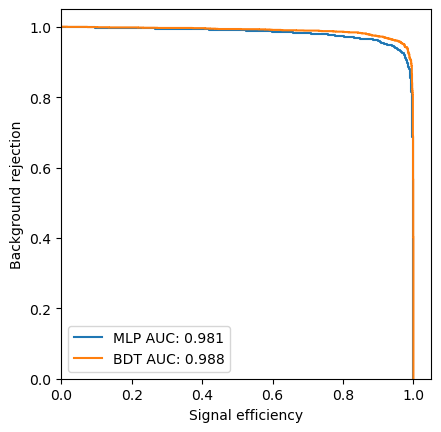

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.3f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.3f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0,1.05)
ax.set_ylim(0,1.05)
fig.savefig("truece.pdf")

Now we save our model in HDF5 format.  This can be used as input to the SOFIE parser.  Note that the kernel must be restarted when saving this file, as re-running individual cells increments the layer numbers in the hdf5 file, causing the SOFIE parser to fail.

In [11]:
output_model.set_weights(model_ce.get_weights())
output_model.summary()
output_model.save("TrainBkg.h5")
#model_ce.save("TrainBkg.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 9)]                  0         
                                                                 
 dense (Dense)               (1, 10)                   100       
                                                                 
 dense_1 (Dense)             (1, 10)                   110       
                                                                 
 dense_2 (Dense)             (1, 10)                   110       
                                                                 
 dense_3 (Dense)             (1, 1)                    11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
